# Oklahoma Purchase Credit Card Transactions Analysis
## --By Yidan Li_yl4357


### Import Packages Needed and Data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
df=pd.read_csv('/Users/liyidan/desktop/Anomaly Detection/1. FE&EDA credit card/hw/purchase_credit_card.csv')

### Primary Data Exploration

In [22]:
print(df.head())
print(df.info())
#There are negative values in amount --> treated as refund

   Year-Month  Agency Number                            Agency Name  \
0      201403           2500           OKLAHOMA MILITARY DEPARTMENT   
1      201403          76000                 UNIVERSITY OF OKLAHOMA   
2      201307          80000  OKLA. CAREER AND TECHNOLOGY EDUCATION   
3      201402          34500           DEPARTMENT OF TRANSPORTATION   
4      201309          76000                 UNIVERSITY OF OKLAHOMA   

  Cardholder Last Name Cardholder First Initial       Description    Amount  \
0               MCCALL                        L  GENERAL PURCHASE -42863.04   
1               MECHAM                        S  GENERAL PURCHASE -41740.00   
2              GOODNER                        M  GENERAL PURCHASE -38506.87   
3                Lewis                        G  GENERAL PURCHASE -34108.00   
4               LARSON                        B  GENERAL PURCHASE -33075.32   

                    Vendor Transaction Date   Posted Date  \
0  SUNSHINE INDUSTRIES INC     2/26/1

#### change column names

In [23]:
df.columns=['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
      'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor', 'Transaction_Date',
      'Posted_Date', 'Merchant_Category']

#### convert 'Transaction Date' from object to datetime

In [24]:
from datetime import datetime, timedelta 
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])

#### Is there correlation between transaction frequency and amount for cardholders?

In [25]:
from scipy.stats import pearsonr
frequency=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial']).Amount.count()
amount=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial']).Amount.mean()
corr, _ = pearsonr(frequency, amount)
print('Pearsons correlation: %.3f' % corr) 

Pearsons correlation: -0.003


There's basically no correlation between the frequency a cardholder uses the card and the amount they spend, therefore it's necessary to explor both frequency and monetary.

#### Total amount spent ranked by agency

[Text(0, 0, 'OKLAHOMA STATE UNIVERSITY'),
 Text(0, 0, 'UNIVERSITY OF OKLAHOMA'),
 Text(0, 0, 'UNIV. OF OKLA. HEALTH SCIENCES CENTER'),
 Text(0, 0, 'GRAND RIVER DAM AUTH.'),
 Text(0, 0, 'DEPARTMENT OF TRANSPORTATION'),
 Text(0, 0, 'DEPARTMENT OF CORRECTIONS'),
 Text(0, 0, 'DEPARTMENT OF TOURISM AND RECREATION'),
 Text(0, 0, 'DEPARTMENT OF VETERANS AFFAIRS'),
 Text(0, 0, 'OFFICE OF MANAGEMENT AND ENTERPRISE SERV'),
 Text(0, 0, 'OKLAHOMA MILITARY DEPARTMENT'),
 Text(0, 0, 'DEPARTMENT OF REHABILITATION SERVICES'),
 Text(0, 0, 'STATE DEPARTMENT OF HEALTH'),
 Text(0, 0, 'DEPARTMENT OF PUBLIC SAFETY'),
 Text(0, 0, 'MENTAL HEALTH AND SUBSTANCE ABUSE SERV.'),
 Text(0, 0, 'HISTORICAL SOCIETY')]

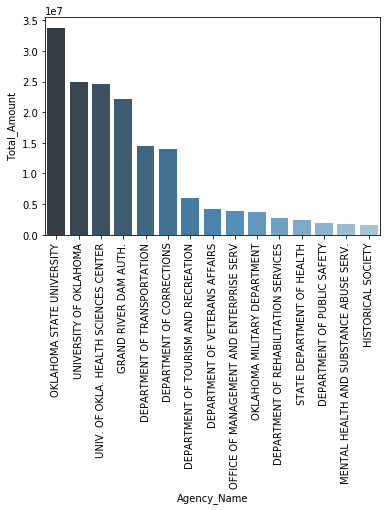

In [26]:
sum_amount_agency=df.groupby('Agency_Name').Amount.sum().sort_values(ascending=False).reset_index(name='Total_Amount')
#reset_index can convert the series from 'groupby' to a dataframe
chart=sns.barplot(data=sum_amount_agency.head(15),x='Agency_Name',y='Total_Amount',palette="Blues_d")
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

Here I get the top agencies that spent most in the dataset, the bar chart illustrates the relative amount they spent. The amount spent varies pretty much across different agencies.

#### Total amount spent ranked by merchant type

[Text(0, 0, 'DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP AND SUP.'),
 Text(0, 0, 'INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED'),
 Text(0, 0, 'COMPUTERS, COMPUTER PERIPHERAL EQUIPMENT, SOFTWARE'),
 Text(0, 0, 'COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED'),
 Text(0, 0, 'MISCELLANEOUS AND SPECIALTY RETAIL STORES'),
 Text(0, 0, 'AMERICAN AIRLINES'),
 Text(0, 0, 'BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED'),
 Text(0, 0, 'STATIONERY, OFFICE SUPPLIES, PRINTING AND WRITING PAPER'),
 Text(0, 0, 'DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE CLASSIFIED'),
 Text(0, 0, 'OTHER FEES'),
 Text(0, 0, 'ELECTRICAL PARTS AND EQUIPMENT'),
 Text(0, 0, 'GOVERNMENT SERVICES--NOT ELSEWHERE CLASSIFIED'),
 Text(0, 0, 'CHEMICALS AND ALLIED PRODUCTS NOT ELSEWHERE CLASSIFIED'),
 Text(0, 0, 'TELECOMMUNICATION SERVICES'),
 Text(0, 0, 'NON-DURABLE GOODS NOT ELSEWHERE CLASSIFIED')]

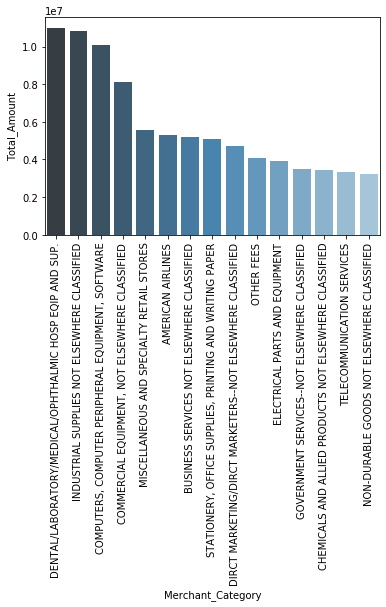

In [27]:
sum_amount_merchant=df.groupby('Merchant_Category').Amount.sum().sort_values(ascending=False).reset_index(name='Total_Amount')
chart=sns.barplot(data=sum_amount_merchant.head(15),x='Merchant_Category',y='Total_Amount',palette="Blues_d")
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

Here I get the top merchant types that the most amount are spent on, the bar chart illustrates the relative amount spent in these categories. The amount spent varies pretty much across different merchants.

#### Total amount spent by month

[Text(0, 0, '201307'),
 Text(0, 0, '201308'),
 Text(0, 0, '201309'),
 Text(0, 0, '201310'),
 Text(0, 0, '201311'),
 Text(0, 0, '201312'),
 Text(0, 0, '201401'),
 Text(0, 0, '201402'),
 Text(0, 0, '201403'),
 Text(0, 0, '201404'),
 Text(0, 0, '201405'),
 Text(0, 0, '201406')]

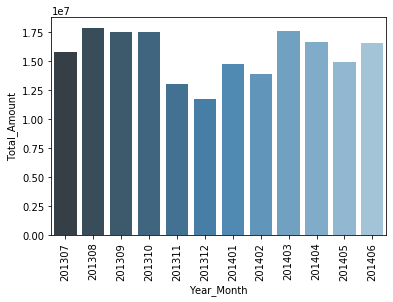

In [28]:
sum_amount_month=df.groupby('Year_Month').Amount.sum().reset_index(name='Total_Amount')
chart=sns.barplot(data=sum_amount_month,x='Year_Month',y='Total_Amount',palette="Blues_d")
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

Here I get the total transaction amount across the year. It shows that over all the agencies spend more in some months than others, and it would be necessary to look into each month when detecting frauds.

### Feature Engineering

### Recency

In [29]:
snapshot_date=df['Transaction_Date'].max()+timedelta(days=1)
df['Recency'] = df['Transaction_Date'].agg(
   {lambda x: (snapshot_date - x).days})
print(df.head(3))  #Recency is the days past since the transaction (on the snapshot_date)

   Year_Month  Agency_Number                            Agency_Name  \
0      201403           2500           OKLAHOMA MILITARY DEPARTMENT   
1      201403          76000                 UNIVERSITY OF OKLAHOMA   
2      201307          80000  OKLA. CAREER AND TECHNOLOGY EDUCATION   

  Cardholder_Last_Name Cardholder_First_Initial       Description    Amount  \
0               MCCALL                        L  GENERAL PURCHASE -42863.04   
1               MECHAM                        S  GENERAL PURCHASE -41740.00   
2              GOODNER                        M  GENERAL PURCHASE -38506.87   

                    Vendor Transaction_Date   Posted_Date  \
0  SUNSHINE INDUSTRIES INC       2014-02-26   3/4/14 0:00   
1  BIO RAD  NORMN-40001124       2014-03-20  3/21/14 0:00   
2                ORACL OPN       2013-07-06   7/8/13 0:00   

                                   Merchant_Category  Recency  
0         STATIONERY,OFFICE AND SCHOOL SUPPLY STORES      125  
1  DENTAL/LABORATORY/MEDI

### Feature #1 Days passed since last transaction by cardholder and merchant

In [9]:
#create this feature
day_passed_cardholder=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Merchant_Category']).apply(lambda x:x.sort_values(['Recency']))['Recency'].diff()
print(day_passed_cardholder)

Cardholder_Last_Name  Cardholder_First_Initial  Merchant_Category        
15000                 1                         OTHER FEES         438799     NaN
24100                 2                         OTHER FEES         8516      -4.0
                                                                   14542      0.0
                                                                   15108     58.0
                                                                   302590    20.0
                                                                             ... 
russell               s                         TRAVEL AGENCIES    94456      6.0
                                                                   94457      0.0
                                                                   94458      0.0
                                                                   94454      1.0
                                                UNITED AIRLINES    375700     0.0
Name: Recency, Length: 4

#### Why this feature?
This feature shows the recency of a transaction by a cardholder at a merchant type. During fraud, the time interval between transactions will be smaller that it usually is, also, fraud tends to happen in certain merchant types more than others. Using this feature, we can find suspicious transactions if the recency is low for certain merchant types. (Though the dataset only gives the date of transactions, which will make this feature less useful since frauds might happen within a day.)

### Feature #2 Days passed since last transaction by agency and merchant

In [20]:
#create this feature
day_passed_agency_merchant=df.groupby(['Agency_Name','Merchant_Category']).apply(lambda x:x.sort_values(['Recency']))['Recency'].diff()
print(day_passed_agency_merchant)

Agency_Name                      Merchant_Category                                 
ARDMORE HIGHER EDUCATION CENTER  BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED  229913     NaN
                                 CATALOG MERCHANTS                           279245   -20.0
                                                                             126271     1.0
                                                                             329264    51.0
                                                                             2740      32.0
                                                                                       ... 
`DEPARTMENT OF EDUCATION         WYNDHAM HOTELS                              321415    14.0
                                                                             201082    12.0
                                                                             201083     0.0
                                                                             201084     

#### Why this feature?
This feature shows the recency of a transaction by an agency at a merchant type. During fraud, the time interval between transactions will be smaller that it usually is, also, fraud tends to happen in certain merchant types more than others. Using this feature, we can find suspicious transactions if the recency is low for certain merchant types. (Though the dataset only gives the date of transactions, which will make this feature less useful since frauds might happen within a day.)

### Frequency

### Feature #3  transactions a cardholder have at a vendor/total transactions a cardholder has 

In [30]:
#create this feature
total_cardholder_vendor_percent=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Vendor'])['Amount'].count()/df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial'])['Amount'].count()
df3=pd.merge(df,total_cardholder_vendor,how='left',on=['Cardholder_Last_Name','Cardholder_First_Initial','Vendor'])
df3=df3.rename(columns={'Amount_x':'Amount',"Amount_y":"total_cardholder_vendor_percent"})
df3.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,total_cardholder_vendor_percent
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,0.009524
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,0.071429
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,0.006568


#### Why this feature?
This feature shows the frequency of a transaction by an agency at a vendor (divided by total transactions to remove the influence of shopping frequency). For an agency, it might have transactions with certain vendors frequently, while during a fraud, there's a high possibility that the fraudster will go to a verndor that the agency has never had transactions with before. And therefore, if this feature's value is pretty low, which means the transaction is with a new vendor, it deserves more attention.

### Feature #4 Cnt_cardholder_day: Number of  transactions by cardholder in that day

In [31]:
#create this feature
cnt_cardholder_day=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Transaction_Date'])['Agency_Number'].count()
df4=pd.merge(df,cnt_cardholder_day,how='left',on=['Cardholder_Last_Name','Cardholder_First_Initial','Transaction_Date'])
df4=df4.rename(columns={"Agency_Number_x":"Agency_Number","Agency_Number_y":"cnt_cardholder_day"})
df4.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,cnt_cardholder_day
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,4
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,3
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,1


#### Why this feature?
This feature shows the daily use of the credit card by each cardholder. When there's fraud, what happens is that the fraudster will use the cards more frequently than the users usually use the cards. Therefore, by monitoring this feature along with the average number of transactions daily in that month by cardholder (which shows the average frequency of using the card), we can detect potential fraud.

### Feature #5 Average_count_cardholder_daily: Average number of daily transactions by cardholder in a month 

In [32]:
#create this feature
cnt=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Year_Month'])['Agency_Number'].count()/30
df5=pd.merge(df,cnt,how='left',on=['Cardholder_Last_Name','Cardholder_First_Initial','Year_Month'])
df5=df5.rename(columns={"Agency_Number_x": "Agency_Number","Agency_Number_y":"average_count_cardholder_daily"})
df5.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,average_count_cardholder_daily
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2.233333
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,0.166667
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2.133333


#### Why this feature?
This feature shows the overall frquency of daily use of the credit card by each cardholder. When there's fraud, what happens is that the fraudster will use the cards more frequently than the users usually use the cards. Therefore, by monitoring this feature along with the number of transaction in that day by cardholder, we can detect potential fraud.

### Feature #6 Cnt_cardholder_merchant_month: Number of transactions by cardholder and by merchant in a month

In [33]:
#create this feature
cnt_cardholder_merchant_month=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Merchant_Category','Year_Month'])['Amount'].count()
df6=pd.merge(df,cnt_cardholder_merchant_month,how='left',on=['Cardholder_Last_Name','Cardholder_First_Initial','Merchant_Category','Year_Month'])
df6=df6.rename(columns={"Amount_x": "Amount","Amount_y":"cnt_cardholder_merchant_month"})
df6.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,cnt_cardholder_merchant_month
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,4
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,4
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2


#### Why this feature?
This feature shows the number of transactions a cardholder has in a certain merchant category during the month.
As fraud tends to occur in merchant categories where the products are easier to be sold again, if this feature gets significantly higher than the average number of transactions by the cardholder in that merchant per month, then the transactions are suspicious.

### Feature #7  Average number of transactions by cardholder and by merchant in a month during the year

In [34]:
#create this feature
df['year'] = pd.DatetimeIndex(df['Transaction_Date']).year
avg_cnt_cardholder_merchant_month=df.groupby(['year','Cardholder_Last_Name','Cardholder_First_Initial','Merchant_Category']).Amount.count()/df.groupby(['year','Cardholder_Last_Name','Cardholder_First_Initial','Merchant_Category']).Year_Month.nunique()
#the total is divided by the number of unique months in that year
df7=pd.merge(df,avg_cnt_cardholder_merchant_month.rename('avg_cnt_cardholder_merchant_month'),how='left',on=['year','Cardholder_Last_Name','Cardholder_First_Initial','Merchant_Category'])
df7.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,avg_cnt_cardholder_merchant_month
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,2.000000
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,3.200000
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,2.666667


#### Why this feature?
Continued with the above feature, this feature gives the average number of transactions a cardholder has in a certain merchant type in a month during a year, which could serves as a benchmark for the above feature of number of transactions by cardholder and by merchant in a month.

### Monetary

### Feature #8 Max_amount_agency_ratio: Trasaction Amount/Maximum amount spent in one transaction by Agency and Merchant Type

In [35]:
#create this feature
max_amount_agency=df.groupby(['Agency_Name','Merchant_Category'])['Amount'].max()
df8=pd.merge(df,max_amount_agency,how='left',on=['Agency_Name','Merchant_Category'])
df8['max_amount_agency_ratio']=df8['Amount_x']/df8['Amount_y']
df8=df8.drop(columns=['Amount_y'])
df8=df8.rename(columns={"Amount_x": "Amount"})
df8.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,max_amount_agency_ratio
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,-0.990000
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,-0.827206
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,-1.000000


#### Why this feature?  
This feature shows the maximum amount spent by an agency for a certain merchant type. I group it by agency and merchant type as the spending pattern differ pretty large across these 2 variables as shown in the statistics below. If a transaction's amount is higher than this maximum amount, which is when the ratio is larger than 1, the transaction deserves more attention.

#### statistical metrics of count of transaction and amount per transaction across merchant categories

In [36]:
df.groupby('Merchant_Category').Amount.describe().sort_values('count',ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
Merchant_Category,,,,,,,,
"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRITING PAPER",24860.0,204.915215,523.628078,-3382.74,23.500,68.40,188.000,18213.00
BOOK STORES,21981.0,122.411428,262.264735,-4907.22,22.870,51.60,122.920,4981.99
INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED,21669.0,500.573179,2118.583759,-10140.00,59.240,159.41,429.000,96190.38
DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP AND SUP.,20183.0,545.258948,1832.518119,-41740.00,84.885,217.41,510.985,74188.50
"GROCERY STORES,AND SUPERMARKETS",17152.0,74.121967,138.248382,-787.58,15.920,36.76,80.980,3196.00


#### statistical metrics of count of transaction and amount per transaction across agencies

In [38]:
df.groupby('Agency_Name').Amount.describe().sort_values('count',ascending=False).head()
#There are some negative values in amount, which could be refunds on credit cards.

,count,mean,std,min,25%,50%,75%,max
Agency_Name,,,,,,,,
OKLAHOMA STATE UNIVERSITY,115995.0,291.209448,598.697354,-6266.53,33.2900,100.00,299.480,27967.38
UNIVERSITY OF OKLAHOMA,76143.0,326.837436,1428.780996,-41740.00,20.0000,70.82,315.625,114203.17
UNIV. OF OKLA. HEALTH SCIENCES CENTER,58247.0,421.091646,10794.681318,-7188.61,29.8750,105.01,351.000,1903858.37
DEPARTMENT OF CORRECTIONS,22322.0,626.685418,2081.553400,-20000.00,59.8625,175.86,514.110,96190.38
DEPARTMENT OF TOURISM AND RECREATION,17232.0,346.557874,1260.856921,-5134.83,39.9500,109.81,309.120,61000.72


### Feature #9  Max_amount_cardholder_ratio: Transaction Amount/Maximum amount spent in one transaction by Cardholder and Merchant Type

In [41]:
#create this feature
max_amount_cardholder=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Merchant_Category'])['Amount'].max()
df9=pd.merge(df,max_amount_cardholder,how='left',on=['Cardholder_Last_Name','Cardholder_First_Initial','Merchant_Category'])
df9['max_amount_agency_ratio']=df9['Amount_x']/df9['Amount_y']
df9=df9.drop(columns=['Amount_y'])
df9=df9.rename(columns={"Amount_x": "Amount"})
df9.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,max_amount_agency_ratio
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,-0.990000
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,-0.677814
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,-1.000000


#### Why this feature?  
This feature shows the maximum amount spent by a cardholder for a certain merchant type. I group it by cardholder and merchant type as the spending pattern differ pretty large across these 2 variables as shown in the statistics above. If a transaction's amount is higher than this maximum amount, which is when the ratio is larger than 1, the transaction deserves more attention.

### Feature #10 Average amount per transaction by agency by merchant category

In [42]:
avg_amount_agency_merchant=df.groupby(['Agency_Name','Merchant_Category'])['Amount'].mean()
df10=pd.merge(df,avg_amount_agency_merchant,how='left',on=['Agency_Name','Merchant_Category'])
df10=df10.rename(columns={"Amount_x": "Amount",'Amount_y':'avg_amount_agency_merchant'})
df10.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,avg_amount_agency_merchant
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,149.098537
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,612.423770
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,1201.135833


#### Why this feature?
This feature shows the average amount spent by an agency for a certain merchant type. As also shown in the above statistics, the mean spending for different merchants differ largely and therefore this feature would capture this part of information and help detect if a transaction is suspicious by comparing with the average spending of the agency on this merchant, since during fraud, a fraudster will try to abuse the card as much as possible.

### Feature #11 Average amount per transaction by cardholder by merchant category

In [43]:
avg_amount_cardholder_merchant=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Merchant_Category'])['Amount'].mean()
df11=pd.merge(df,avg_amount_cardholder_merchant,how='left',on=['Cardholder_Last_Name','Cardholder_First_Initial','Merchant_Category'])
df11=df11.rename(columns={"Amount_x": "Amount",'Amount_y':'avg_amount_cardholder_merchant'})
df11.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,avg_amount_cardholder_merchant
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,163.461667
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,11775.997333
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,1201.135833


#### Why this feature?
This feature shows the average amount spent by a cardholder for a certain merchant type. As also shown in the above statistics, the mean spending for different merchant types differ largely and therefore this feature would capture this part of information and help detect if a transaction is suspicious by comparing with the average spending of the cardholder on this merchant, since during fraud, a fraudster will try to abuse the card as much as possible.

### Feature #12 Total amount spent on the same day by cardholder

In [44]:
total_amount_daily_cardholder=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Transaction_Date'])['Amount'].sum()
df12=pd.merge(df,total_amount_daily_cardholder,how='left',on=['Cardholder_Last_Name','Cardholder_First_Initial','Transaction_Date'])
df12=df12.rename(columns={"Amount_x": "Amount",'Amount_y':'total_amount_daily_cardholder'})
df12.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,total_amount_daily_cardholder
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,-41550.22
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,-50459.00
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,-38506.87


#### Why this feature?
As most credit frand happens in a short period of time, this feature could capture the amount a cardholder spends in a single day, which could be then compared with the cardholder's average daily spending and see if this day is a usual day or not.

### Feature #13 Total amount spent on the same day by agency

In [45]:
total_amount_daily_agency=df.groupby(['Agency_Name','Transaction_Date'])['Amount'].sum()
df13=pd.merge(df,total_amount_daily_agency,how='left',on=['Agency_Name','Transaction_Date'])
df13=df13.rename(columns={"Amount_x": "Amount",'Amount_y':'total_amount_daily_agency'})
df13.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,total_amount_daily_agency
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,-33979.89
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,11404.78
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,-37971.07


#### Why this feature?
Similar to the above feature, this feature could capture the amount an agency spends in a single day, which could be then compared with the agency's average daily spending and see if this day is a usual day or not.

### Feature #14 Average amount spent daily by cardholder in a month

In [46]:
#create the feature
average_amount_cardholder_month=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Year_Month'])['Amount'].mean()
df14=pd.merge(df,average_amount_cardholder_month,how='left',on=['Cardholder_Last_Name','Cardholder_First_Initial','Year_Month'])
df14=df14.rename(columns={"Amount_x": "Amount",'Amount_y':'average_amount_cardholder_month'})
df14.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,average_amount_cardholder_month
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,406.785075
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,1010.520000
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,250.917344


#### Why this feature?
Average amount spent daily by the cardholder during a month could illustrate the average daily spending pattern of the cardholder, which can be compared with the above generated total amount spent on the same day by the cardholder and see if that day's transaction is normal or not.

### Feature #15 Average amount spent daily by agency in a month

In [47]:
#create the feature
average_amount_agency_month=df.groupby(['Agency_Name','Year_Month'])['Amount'].mean()
df15=pd.merge(df,average_amount_agency_month,how='left',on=['Agency_Name','Year_Month'])
df15=df15.rename(columns={"Amount_x": "Amount",'Amount_y':'average_amount_agency_month'})
df15.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,average_amount_agency_month
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,494.910560
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,341.752671
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,311.611393


#### Why this feature?
Average amount spent daily by the agency during a month could illustrate the average daily spending pattern of the agency, which can be compared with the above generated total amount spent on the same day by the agency and see if that day's transaction is normal or not.

### Feature #16 Max amount of transaction in each vendor

In [48]:
#create the feature
max_amount_vendor=df.groupby(['Vendor'])['Amount'].max()
df16=pd.merge(df,max_amount_vendor,how='left',on=['Vendor'])
df16=df16.rename(columns={"Amount_x": "Amount",'Amount_y':'max_amount_vendor'})
df16.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,max_amount_vendor
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,58875.00
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,50459.00
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,38506.87


#### Why this feature?
This feature shows the maximum amount of all transactions in a vendor. Different vendors have different business and have different levels of transaction amount, identifying this feature can shows the upper bound at the vendor. During a fraud, the fraudster might want to spend a lot at a vendor, so comparing the amount with the maximum amount in the vendor can be helpful. If the amount is close to or even exceeds the maximum, the transaction deserves more attention.

### Feature #17 Average amount of transaction in each vendor

In [49]:
#create the feature
avg_amount_vendor=df.groupby(['Vendor'])['Amount'].mean()
df17=pd.merge(df,avg_amount_vendor,how='left',on=['Vendor'])
df17=df17.rename(columns={"Amount_x": "Amount",'Amount_y':'avg_amount_vendor'})
df17.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,avg_amount_vendor
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,1323.581618
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,0.000000
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,1181.176250


#### Why this feature?
This feature shows the average amount of all transactions in a vendor. Different vendors have different business and have different levels of transaction amount, identifying this feature can shows the average level of spending at the vendor. During a fraud, the fraudster might want to spend a lot at a vendor, so comparing the amount with this average amount in the vendor can be helpful. If the amount is significantly above the average, the transaction deserves more attention.

### Variety

### Feature #18 cnt_merchant_cardholder_day: Number of different merchant type by cardholder in a day

In [50]:
#create the feature
cnt_merchant_cardholder_day=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Transaction_Date'])['Merchant_Category'].nunique()
df18=pd.merge(df,cnt_merchant_cardholder_day,how='left',on=['Cardholder_Last_Name','Cardholder_First_Initial','Transaction_Date'])
df18=df18.rename(columns={"Merchant_Category_x": "Merchant_Category",'Merchant_Category_y':'cnt_merchant_cardholder_day'})
df18.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,cnt_merchant_cardholder_day
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,4
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,1
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,1


#### Why this feature?
This feature shows the variety of merchant the cardholder spends money on during a day. During a fraud, the card could possibly be used in many different merchant types, more than the cardholder would usually do. Therefore, if this feature is significantly higher than it normally is, the transactions could be suspicious.

### Feature #19 cnt_vendor_cardholder_day: Number of different vendors by cardholder in a day

In [51]:
#create the feature
cnt_vendor_cardholder_day=df.groupby(['Cardholder_Last_Name','Cardholder_First_Initial','Transaction_Date'])['Vendor'].nunique()
df19=pd.merge(df,cnt_vendor_cardholder_day,how='left',on=['Cardholder_Last_Name','Cardholder_First_Initial','Transaction_Date'])
df19=df19.rename(columns={"Vendor_x": "Vendor",'Vendor_y':'cnt_vendor_cardholder_day'})
df19.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,cnt_vendor_cardholder_day
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,4
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,1
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,1


#### Why this feature?
This feature shows the variety of vendors the cardholder spends money on during a day. During a fraud, the card could possibly be used in many different vendors, more than the cardholder would usually do. Therefore, if this feature is significantly higher than it normally is, the transactions could be suspicious.

### Feature #20 refunder: whether the amount is negative or not

In [52]:
filter_method = lambda x: 'refund' if x < 0 else 'non_refund'
df20=df
df20['refunder'] = df20['Amount'].apply(filter_method)
df20.head(3)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Recency,year,refunder
0,201403,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,-42863.04,SUNSHINE INDUSTRIES INC,2014-02-26,3/4/14 0:00,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",125,2014,refund
1,201403,76000,UNIVERSITY OF OKLAHOMA,MECHAM,S,GENERAL PURCHASE,-41740.00,BIO RAD NORMN-40001124,2014-03-20,3/21/14 0:00,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,103,2014,refund
2,201307,80000,OKLA. CAREER AND TECHNOLOGY EDUCATION,GOODNER,M,GENERAL PURCHASE,-38506.87,ORACL OPN,2013-07-06,7/8/13 0:00,COMPUTER SOFTWARE STORES,360,2013,refund


#### Why this feature?
This feature divide refund transactions and non-refund transactions. As fraud transactions are those spend money in exchange for goods, we can expect higher fraud rate in non-refund transactions than in refund transactions.


### Summary
I created the above features mainly based on RFM.
The work has many limitations. 
First,because the data doesn't have the sequence within a day, this part of information can't be used to create features, especially for evaluating recency.
Second, for some average features, I directly used the average in that month for simplicity, but it would be better to update to a rolling window like the past 30 days, so that the features could be applied to newly generated transactions. 